In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from numpy.random import multivariate_normal as mvnorm
from numpy.linalg import norm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
%matplotlib inline

import pdb, time

seed = 0
np.random.seed(seed)

### Import and generate data

In [2]:
# Standardised Fama French 5 to industry portfolio 30
# Import data
data = pd.read_pickle("/Users/sikai/Downloads/ff5_30_nonsmooth_standard_4000_draws.pkl")

# # Restrict to 100 time points
X = data[10:110].transpose(2, 1, 0)
X_cov = np.einsum('ijkl,jmkl->imkl', np.expand_dims(X, 1), np.expand_dims(X, 0))

### Train

In [3]:
n_dimensions, _, n_samples, time_steps = X_cov.shape
emp_inv = []
for i in range(time_steps):
    emp_inv.append(np.linalg.inv(np.mean(X_cov[:, :, :, i], 2)))
emp_inv = np.array(emp_inv)

In [32]:
from regain.covariance import GradientEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_g = GradientEqualTimeGraphicalLasso(max_iter=10000, loss='LL', c_level=0.2, theta=0.5, rho=1e3, mult=2, weights=None, m=100, eps=2, psi="laplacian")
emp_inv_score_g, baseline_score_g, fit_score_g, pre_g = tgl_g.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

0
-6.883652684028171 -7.763555248017257
51019.90829294012
100
-7.697806836404197e-10 -6.739917379901064
48879.35322708108
200
3.778621859851228e-10 -5.678393847197619
47011.01153196045
300
2.8767299653509326e-10 -4.848218051730497
45356.09200704103
400
-8.58442206208565e-11 -4.189938407887641
43879.86592513648
500
3.552287353159045e-10 -3.6460481385546553
42553.50632786816
600
3.079634325331426e-10 -3.1741493455792784
41354.207863706055
700
-2.7995383788947947e-12 -2.787875075443588
40263.80828405216
800
1.7182166800466803e-10 -2.468367834821251
39265.566985840065
900
1.4411227766686352e-10 -2.194014242315552
38345.12449246268
1000
1.617461720115898e-10 -1.9556341782960311
37490.96202846021
1100
1.7356382997490982e-10 -1.761361964395047
36694.25942877816
1200
3.3839553381653786e-10 -1.5957070608945652
35947.08221165456
1300
6.003300079271412e-10 -1.4583382230892648
35242.85491311137
1400
1.0046430354293534e-09 -1.3325957345256325
34576.40240963686
1500
1.7704446797495166e-09 -1.2134376

/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/gradient_equal_time_graphical_lasso.py:376: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [38]:
from regain.covariance import TaylorEqualTimeGraphicalLasso, TimeGraphicalLasso
tic = time.perf_counter()
tgl_tp = TaylorEqualTimeGraphicalLasso(max_iter=10000, loss='LL', c_level=0.2, theta=0.5, rho=2e3, mult=1.1, weights=None, m=100, eps=2, psi="laplacian")
emp_inv_score_tp, baseline_score_tp, fit_score_tp, pre_tp = tgl_tp.fit_cov(X_cov).eval_cov_pre() 
toc = time.perf_counter()
print('Running Time :{}'.format(toc - tic))
# min_pre_tp = np.amin(np.abs(pre_tp[pre_tp != 0]))

0
-6.883652684028171 -7.763555248017257
51019.90829294012
100
0.07632046518843083 -6.739075057180818
48879.35006658573


/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


200
0.1517101113205257 -5.676127226360091
47010.999194332144
300
0.21142493506040472 -4.841903538422748
45356.02654373516
400
0.19990975665811206 -4.183916540098373
43879.80605763411
500
0.1620611967726182 -3.6414063892186515
42553.43423996141
600
0.21158777062396794 -3.1674996662353396
41354.08435092204
700
0.21367058640532655 -2.7785311364290872
40263.528057840944
800
0.18543825347469145 -2.457798319888161
39265.26716016071


/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


900
0.22502155918063593 -2.1832086685333336
38344.83029540742
1000
0.2098012861008529 -1.9446668408072356
37490.61602724903
1100
0.24238478609683867 -1.748163888698798
36693.80378115949
1200
0.23239793232104233 -1.5827267900869209
35946.64205560974
1300
0.2266848242642414 -1.4439255487781708
35242.23063218807
1400
0.12523190024165487 -1.32203348952186
34575.943012957636
1500
0.06932675290380885 -1.2035329122695198
33942.293073175664
1600
0.2083500926003623 -1.0928346704540732
33338.0157508064
1700
0.2680283248296469 -0.9910855224162853
32759.88537289555
1800
0.27867310706202364 -0.897814543710005
32205.60688738027
1900
0.239373948457537 -0.8066503488112972
31672.1842717492
2000
0.36710530554556087 -0.7275702803475746
31158.200657445093
2100
0.16831325723878976 -0.6571209223361315
30662.821369717672
2200
0.4068716088169744 -0.5855700016677691
30183.96822264891
2300
0.323286457064615 -0.5183177493441459
29720.930876430062
2400
0.34395727581810576 -0.45582916736291496
29272.43357967238
25

9100
2.380715019634623 0.2586669536279018
20687.351017302746
Rho Mult 160359.06410722723 9113 0.2588385557727381 2.3762670965846144
9200
2.3459207521091887 0.2613044862564198
20684.168289304296
Rho Mult 176394.97051794996 9214 0.2615025463625238 2.3410820251108166
9300
2.3111067891868604 0.2638572743570676
20681.265250065528
Rho Mult 194034.46756974497 9315 0.2640804847856318 2.305948385045257
9400
2.2762610440608615 0.2663226458510637
20678.61832790878
Rho Mult 213437.91432671947 9416 0.26656919532209444 2.2707165109833074
9500
2.2413791217515087 0.26870031920199244
20676.20630342694
Rho Mult 234781.70575939145 9517 0.2689680612344128 2.235501705220651
9600
2.206479247285637 0.2709877321960099
20674.009998352776
Rho Mult 258259.87633533063 9618 0.27127345874830155 2.200227788557962
9700
2.171590575850532 0.27318379821027206
20672.011431533465
Rho Mult 284085.86396886373 9719 0.2734846043216173 2.165005392052594
9800
2.1367150343521093 0.27528839099274416
20670.194655776242
Rho Mult 31

/Users/sikai/Dropbox/Research/post_sum/code/regain/regain/covariance/taylor_equal_time_graphical_lasso.py:382: UserWarning: Objective did not converge.
  warnings.warn("Objective did not converge.")


In [33]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_g_thres = {}
fit_score_g_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_g_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_g])
    tgl_g.precision_ = pre_g_thres[i]
    emp_inv_score, baseline_score, fit_score_g_thres[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre_g_thres[i], pre_g_thres[i][:-1], pre_g_thres[i][1:], psi, tgl_g.theta))

16792.499278939013
16792.504145111667
16792.504148266948


In [39]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_tp.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre_tp_thres = {}
fit_score_tp_thres = {}
for i in [1e-4, 1e-6, 0]:
    pre_tp_thres[i] = np.array([k * (np.abs(k) >= i) for k in pre_tp])
    tgl_tp.precision_ = pre_tp_thres[i]
    emp_inv_score, baseline_score, fit_score_tp_thres[i], _ = tgl_tp.eval_cov_pre() 
    print(penalty_objective(pre_tp_thres[i], pre_tp_thres[i][:-1], pre_tp_thres[i][1:], psi, tgl_tp.theta))

20667.061148214067
20667.06209051531
20667.06209090836


In [8]:
from regain.covariance import CVXInequalityTimeGraphicalLasso, TimeGraphicalLasso
pre_cvx = np.load("mosek_sol_ff5_30_standard_alpha_0.2.npy")

In [9]:
from regain.norm import l1_od_norm
from regain.validation import check_norm_prox
psi, prox_psi, psi_node_penalty = check_norm_prox(tgl_g.psi)

def penalty_objective(Z_0, Z_1, Z_2, psi, theta):
    """Penalty-only objective function for time-varying graphical LASSO."""
    return theta * sum(map(l1_od_norm, Z_0)) + (1 - theta) * sum(map(psi, Z_2 - Z_1))

pre = {}
fit_score = {}
# for i in [1e-2, 1e-3, 1e-4, 1e-6]:
for i in [1e-4]:
    pre[i] = np.array([k * (np.abs(k) >= i) for k in pre_cvx])
    tgl_g.precision_ = pre[i]
    emp_inv_score, baseline_score, fit_score[i], _ = tgl_g.eval_cov_pre() 
    print(penalty_objective(pre[i], pre[i][:-1], pre[i][1:], psi, tgl_g.theta))

5951.380304945549


In [10]:
tgl = TimeGraphicalLasso(alpha=1., beta=1., mode='admm', rho=1, tol=1e-4,
            rtol=1e-4, psi='laplacian', max_iter=3000, verbose=False, assume_centered=False, 
            return_history=False, update_rho_options=None, compute_objective=True, 
            stop_at=None, stop_when=1e-4, suppress_warn_list=False, init='empirical')
fit_score_, pre_ = tgl.fit_cov(X_cov).eval_cov_pre()   

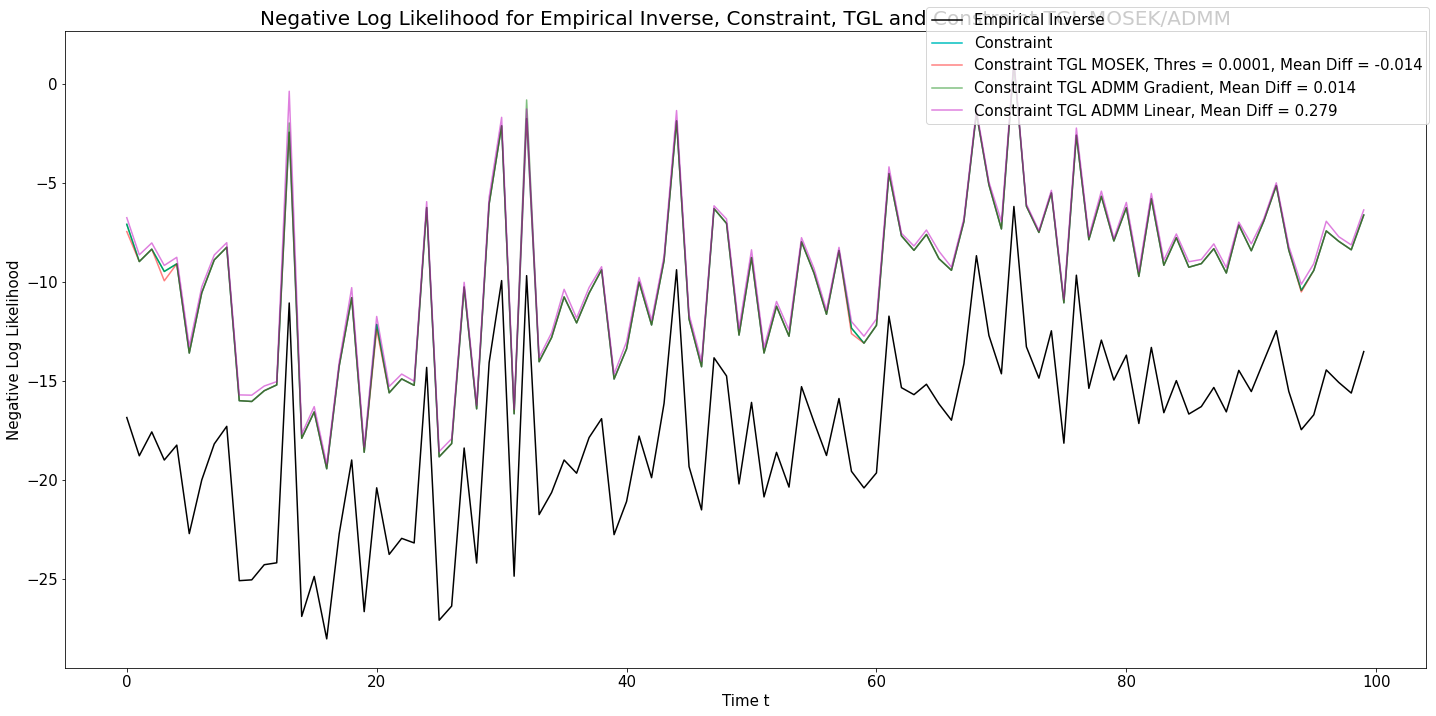

In [40]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

ax.plot(range(X_cov.shape[-1]), emp_inv_score_g, color='k', label=r'Empirical Inverse')
ax.plot(range(X_cov.shape[-1]), baseline_score_g, color='c', label=r'Constraint')
for i in [1e-4]:
    mean_diff = np.mean(np.array(fit_score[i]) - baseline_score)
    ax.plot(range(X_cov.shape[-1]), fit_score[i], color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), fit_score[i], color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# mean_diff = np.mean(np.array(fit_score_grad) - baseline_score_grad)
# ax.plot(range(X_cov.shape[-1]), fit_score_grad, alpha=0.5, color='m',
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
# mean_diff = np.mean(np.array(fit_score_tp) - baseline_score_tp)
mean_diff = np.mean(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_g_thres[1e-4], alpha=0.5, color='g',
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(mean_diff))
mean_diff = np.mean(np.array(fit_score_tp_thres[1e-4]) - baseline_score_tp)
# ax.plot(range(X_cov.shape[-1]), fit_score_tp, alpha=0.5, color='g',
ax.plot(range(X_cov.shape[-1]), fit_score_tp_thres[1e-4], alpha=0.5, color='m',
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(mean_diff))

# mean_diff = np.mean(np.array(fit_score_) - res[1][1])
# ax.plot(range(X_cov.shape[-1]), fit_score_, color='y', label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(mean_diff))

fig.legend(fontsize=15)
ax.set_ylabel('Negative Log Likelihood', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Negative Log Likelihood for Empirical Inverse, Constraint, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_10000_diff_like_indiv.pdf')

In [41]:
np.log(np.array(fit_score_g_thres[1e-4]) - baseline_score_g)

/Users/sikai/.pyenv/versions/3.7.6/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


array([         nan, -23.6464316 ,          nan, -21.06178218,
                nan,          nan,          nan,          nan,
                nan,          nan, -24.43005036, -10.12910677,
                nan,  -0.75626747, -24.04043159, -11.3533957 ,
       -24.79178105,          nan,          nan, -13.54148392,
       -10.91707957,          nan,          nan,          nan,
        -6.28058938, -27.35217081,          nan,          nan,
                nan, -11.17757148, -11.06539122, -11.9602523 ,
        -0.06064759,          nan,          nan, -10.72630075,
       -10.71253405, -10.99434191,          nan, -26.22659556,
       -12.1598019 , -11.17633428,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan, -16.6193391 ,          nan,
       -10.0791956 , -25.5649017 , -10.83339628,          nan,
        -9.84406951, -10.03171256,          nan, -24.87333092,
       -10.47244263,          nan,  -8.39697311, -10.33

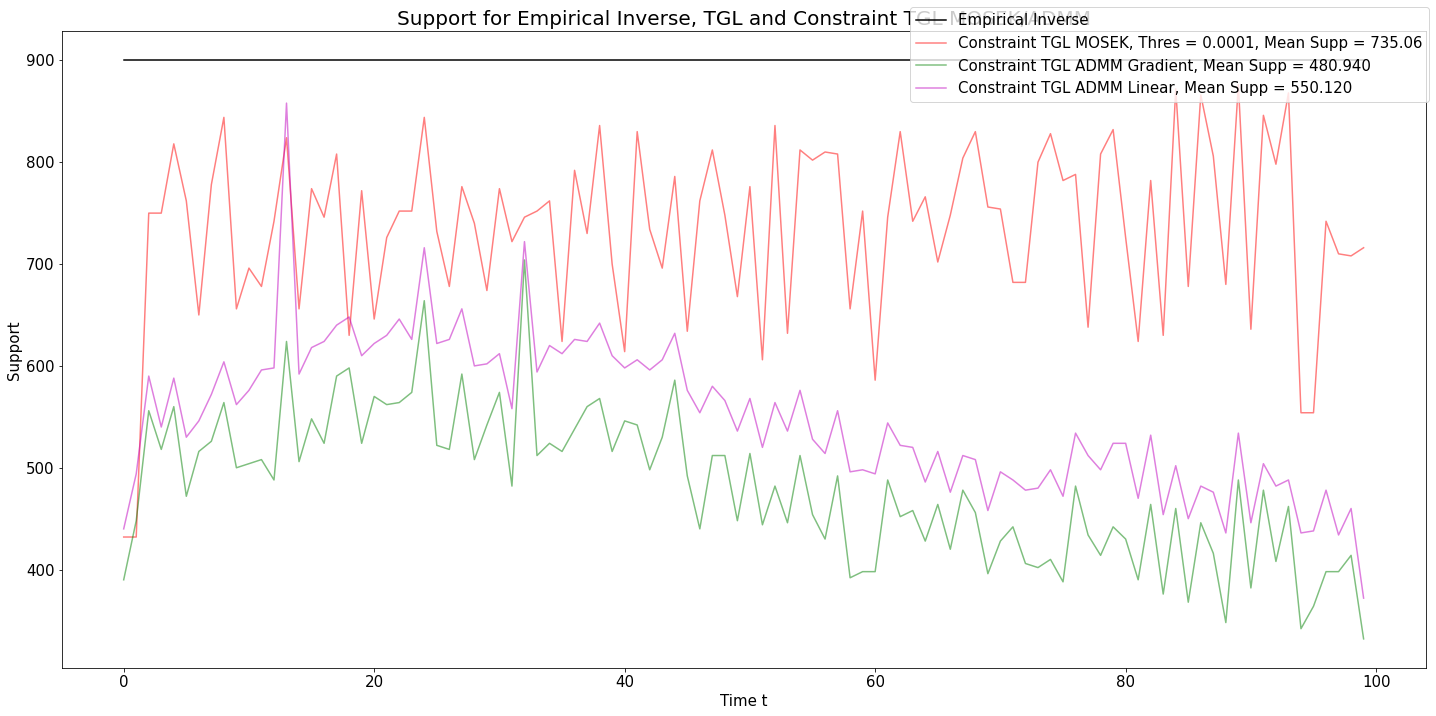

In [42]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(emp_inv[k]) > 0)) for k in range(X_cov.shape[-1])], 
        color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    supp = [sum(sum(abs(pre[i][t]) > 0)) for t in range(X_cov.shape[-1])]
    mean_supp = np.mean(supp)
    ax.plot(range(X_cov.shape[-1]), supp, color='r', alpha=0.5, 
#     ax.plot(range(X_cov.shape[-1]), supp, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Supp = {}'.format(i, mean_supp))
    color_index += 1
# supp = [sum(sum(abs(pre_grad[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_g_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Supp = {:.3f}'.format(np.mean(supp)))
supp = [sum(sum(abs(pre_tp_thres[1e-4][t]) > 0)) for t in range(X_cov.shape[-1])]
# supp = [sum(sum(abs(pre_tp[t]) > 0)) for t in range(X_cov.shape[-1])]
ax.plot(range(X_cov.shape[-1]), supp, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Supp = {:.3f}'.format(np.mean(supp)))
# supp = [sum(sum(abs(pre_[t]) > 0)) for t in range(X_cov.shape[-1])]
# ax.plot(range(X_cov.shape[-1]), [sum(sum(abs(pre_[k]) > 0)) for k in range(X_cov.shape[-1])], 
#         color='y', label=r'Vanilla TGL, , Mean Supp = {:.3f}'.format(np.mean(supp)))


fig.legend(fontsize=15)
ax.set_ylabel('Support', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Support for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_10000_diff_supp_indiv.pdf')

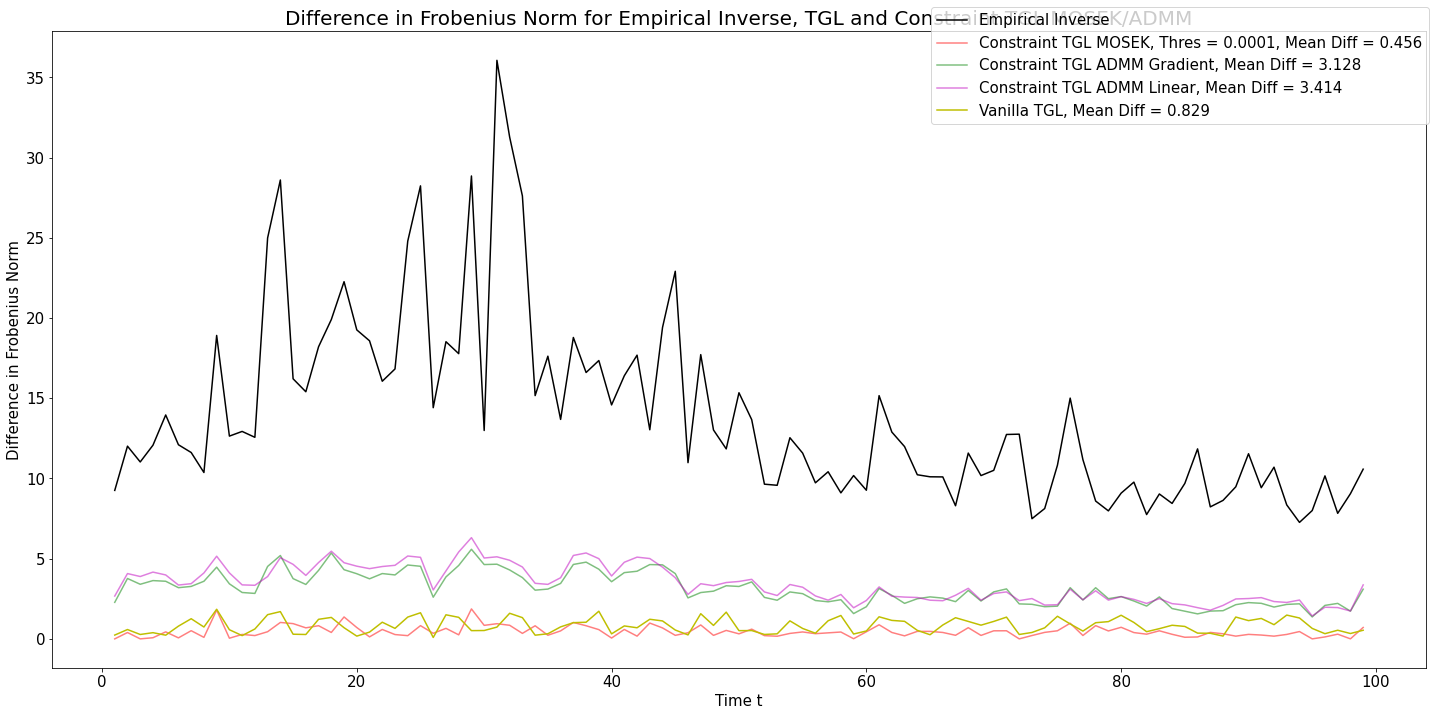

In [43]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

diff_emp = [norm(emp_inv[t] - emp_inv[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [norm(pre[i][t] - pre[i][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_g_thres[1e-4][t] - pre_g_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], 'fro') for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [norm(pre_[t] - pre_[t-1], 'fro') for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

fig.legend(fontsize=15)
ax.set_ylabel('Difference in Frobenius Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in Frobenius Norm for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
plt.savefig('ff5_ip30_10000_diff_fro_indiv.pdf')

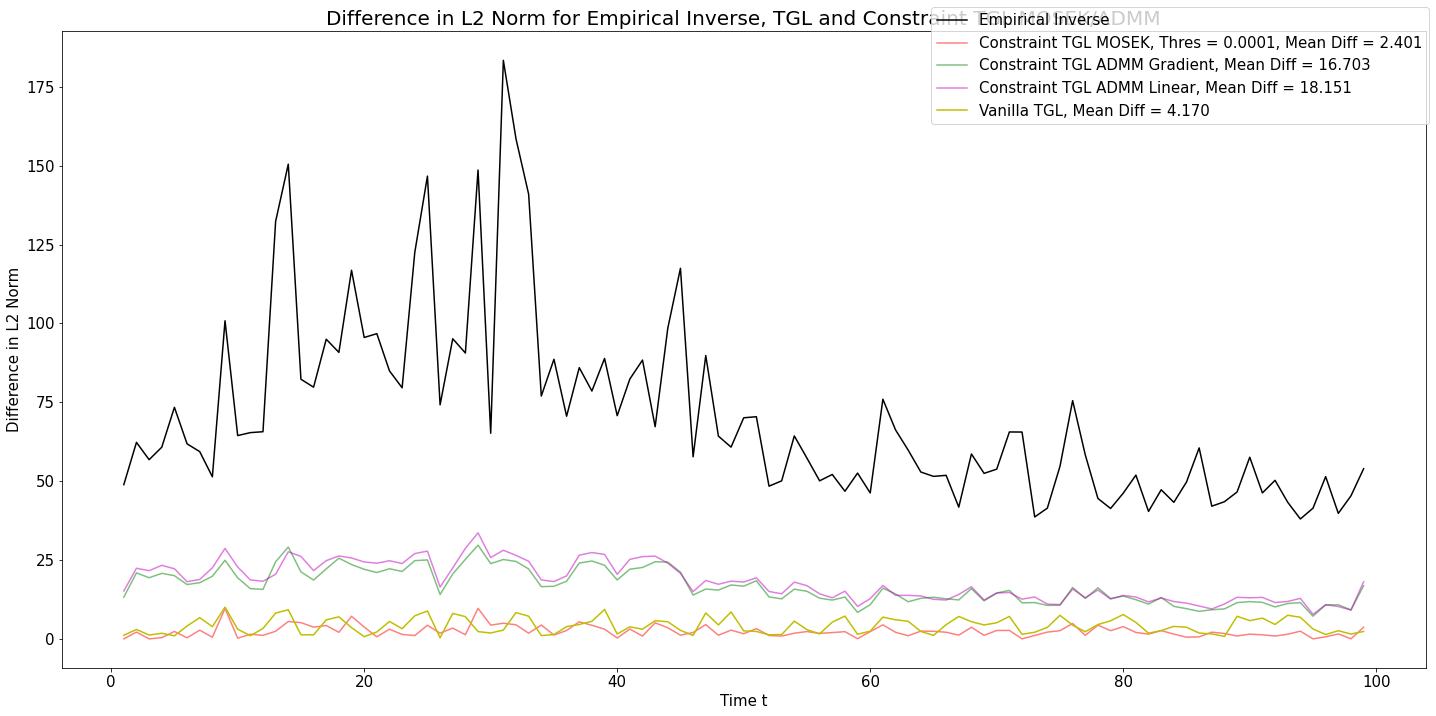

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.patch.set_facecolor('white')
colors = "rgb"
color_index = 0

diff_emp = [np.sum(norm(emp_inv[t] - emp_inv[t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_emp), alpha=1, color='k', label=r'Empirical Inverse')
# for i in [min_pre_tp]:
for i in [1e-4]:
    diff = [np.sum(norm(pre[i][t] - pre[i][t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
    mean_diff = np.mean(diff)
    ax.plot(range(1, X_cov.shape[-1]), diff, color='r', alpha=0.5, 
#     ax.plot(range(1, X_cov.shape[-1]), diff, color=colors[color_index], alpha=0.5, 
            label=r'Constraint TGL MOSEK, Thres = {}, Mean Diff = {:.3f}'.format(i, mean_diff))
    color_index += 1
# diff_grad = [norm(pre_grad[t] - pre_grad[t-1], axis=1) for t in range(1, X_cov.shape[-1])]
# ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
#         label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [np.sum(norm(pre_g_thres[1e-4][t] - pre_g_thres[1e-4][t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], axis=1) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='g', alpha=0.5,
        label=r'Constraint TGL ADMM Gradient, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_grad = [np.sum(norm(pre_tp_thres[1e-4][t] - pre_tp_thres[1e-4][t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
# diff_grad = [norm(pre_tp[t] - pre_tp[t-1], axis=1) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), diff_grad, color='m', alpha=0.5,
        label=r'Constraint TGL ADMM Linear, Mean Diff = {:.3f}'.format(np.mean(diff_grad)))
diff_fit_ = [np.sum(norm(pre_[t] - pre_[t-1], axis=1)) for t in range(1, X_cov.shape[-1])]
ax.plot(range(1, X_cov.shape[-1]), np.array(diff_fit_), color='y', alpha=1, 
        label=r'Vanilla TGL, Mean Diff = {:.3f}'.format(np.mean(diff_fit_)))

fig.legend(fontsize=15)
ax.set_ylabel('Difference in L2 Norm', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Time t', fontsize=15)
ax.set_title(r'Difference in L2 Norm for Empirical Inverse, TGL and Constraint TGL MOSEK/ADMM', fontsize=20)
plt.tight_layout()
# plt.savefig('ff5_ip30_40000_diff_fro_max_2_mult_3_div_5.pdf')